In [37]:
%reload_ext autoreload 
%autoreload 2

import pickle 
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import clear_output
from sklearn.metrics import r2_score

import data_parser
import Model


In [38]:
# CUDA
if torch.cuda.is_available():
    dev = "cuda:0"
    print("CUDA avaiable")
else:  
    dev = "cpu"
    print("CUDA not avaiable")
device = torch.device(dev)

CUDA avaiable


In [39]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.0):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            
            nn.Linear(200, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            
            nn.Linear(500, out_features)
        )
        

    def forward(self, x):

        return self.layers(x)


In [40]:
def plot_X_y(X, y, df, indices, input_cols, y_label, pred=None, loss=None, r2=None, mer=None, \
             dirname='', figname=None, savefig=False):
    
    # Plot a 3x3 figure
    line = 5
    fig, ax = plt.subplots(line, 3, figsize=(40, 3 * line), constrained_layout=True)

    # Plot all the examples
    for i in range(line):
        for j in range(3):
        
            idx = indices[i*3+j]
            input_col_str = ''
            for input_col in input_cols:
                input_col_str += input_col + ':%.1f ' % df.loc[idx][input_col][0]
            
            ax[i,j].plot(X.detach().numpy(), y[i*3+j,:].detach().numpy(), label='truth')
            if pred is not None:
                ax[i,j].plot(X.detach().numpy(), pred[i*3+j,:].detach().numpy(), label='predictions')
            ax[i,j].set_xlabel(input_col_str)
            ax[i,j].set_ylabel(y_label)
    title = 'Loss: %.4f R2 : %.4f Max Error Rate : %.4f' % (loss, r2, mer)
    fig.suptitle(title)
    
    if savefig:
        pdf_dir = '../Figures/pdf/%s' % dirname
        png_dir = '../Figures/png/%s' % dirname
        if not os.path.isdir(pdf_dir):
            os.makedirs(pdf_dir)
        if not os.path.isdir(png_dir):
            os.makedirs(png_dir)
        plt.savefig(pdf_dir + figname+'.pdf', bbox_inches= 'tight')
        plt.savefig(png_dir + figname+'.png', bbox_inches= 'tight')
        
    plt.show();
    

In [41]:
case = 'case1'
EM_model = 'Differential_Stripline'
optimetric = 'SweepSetup1'
port = 4
dataname = '%s_%s_%s' %(case, EM_model, optimetric)
in_features = 3
out_features = 501

In [42]:
df = data_parser.calculate_amp_phase(data_parser.data_parse(case, EM_model, port, optimetric), unwrap=True)
df = data_parser.calculate_sin_cos(df)

In [43]:
read_idx = False # Whether to read the index list (trained already)
retrain = True # Whether to train the model

In [44]:
models = {}
predictions = {}

# Randomly shuffle the indices
index_list = list(dict.fromkeys(df.index.get_level_values(0)))
index_file = '../Data/Indices/index_%s.pkl' % dataname
if read_idx == True:
    with open(index_file, 'rb') as f:
        indices = pickle.load(f)
else:
    random.seed(42)
    np.random.shuffle(index_list)
    
    # Split the indices into 80% training set, 10% testing set and 10% validation set
    indices = {}
    indices['train_idx'] = index_list[:int(len(index_list) * 0.8)]
    indices['val_idx'] = index_list[int(len(index_list) * 0.8):int(len(index_list) * 0.9)]
    indices['test_idx'] = index_list[int(len(index_list) * 0.9):]

    with open(index_file, 'wb') as f:
        pickle.dump(indices, f)
    

input_cols = ["W", "Trap", "Length"]


# Define F for plot
F = torch.Tensor(df.loc[indices['train_idx'][0]]['F']).reshape(-1, 1)


In [45]:
i_range = [1, 2, 3, 4]
j_range = [1, 2, 3, 4]
num_epoch = 20000


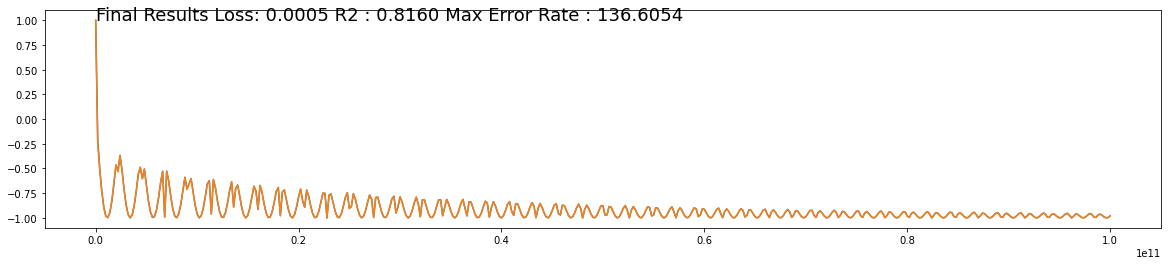

In [46]:
# Train with amplitude and phase    
model_name='SoTA_model'

for i in i_range:
    for j in j_range:
        
        for k in 'A', 'sinP', 'cosP':
            
            # Train A(i, j) and P(i, j)
            output_col = '%s(%1d,%1d)' % (k,i,j)
            network = MLP(in_features, out_features, dropout_rate=0.0)
            models[output_col] = Model.Model(df, network, indices, input_cols, output_col, in_features, out_features, device, postfix=model_name)
            
            # Train the model
            if retrain == True:
                models[output_col].train(0.001, num_epoch)
                predictions[output_col] = models[output_col].test()
            else:
                models[output_col].load_model()
                
            # Test the model
            predictions[output_col] = models[output_col].test()